# Interactive Data Simulation for Predictive Maintenance

This notebook provides an **interactive UI** for generating realistic, physics-based sensor data for **Predictive Maintenance (PdM)** and **Condition Monitoring (CM)** applications.

## Purpose & Use Cases

This notebook solves the common problem of **lacking real sensor data** for developing and testing ML models. It generates synthetic but realistic data that mimics actual industrial equipment behavior.

**Use this notebook to:**
- Generate training datasets for ML models (anomaly detection, fault classification, RUL prediction)
- Test Node-RED flows with realistic sensor streams
- Understand how different fault types affect sensor readings
- Create labeled datasets with known ground truth for model validation

## Features

| Feature | Description |
|---------|-------------|
| **17 Sensor Types** | Vibration, Temperature, Electrical, Process parameters |
| **6 Fault Types** | Normal, Unbalance, Misalignment, Bearing, Overload, Cavitation |
| **Interactive UI** | Sliders, dropdowns, real-time plots |
| **7 Export Formats** | JSON, JSONL, NDJSON for various ML pipelines |
| **Physics-Based** | Realistic correlations between sensors |

## How to Use This Notebook

1. **Run all cells** to initialize the simulator and UI components
2. **Use the Interactive UI** (Section 2) to explore different fault scenarios
3. **Generate Batch Datasets** (Section 3) for ML training
4. **Export to JSON** (Section 5) for Node-RED integration

## Requirements
```bash
pip install ipywidgets numpy pandas matplotlib scipy
```

> **Note:** Interactive widgets only work in a live Jupyter environment, not in static notebook viewers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import os
import json
from datetime import datetime

# Interactive widgets
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    HAS_WIDGETS = True
except ImportError:
    print("Install ipywidgets: pip install ipywidgets")
    HAS_WIDGETS = False

np.random.seed(42)

DATA_DIR = '../data/simulated'
os.makedirs(DATA_DIR, exist_ok=True)

print("Setup complete!")
print(f"Widgets available: {HAS_WIDGETS}")

Setup complete!
Widgets available: True


## 1. Multi-Dimensional Sensor Simulator

### Overview

The `MultiSensorSimulator` class generates **correlated, physics-based sensor data** that mimics real industrial equipment. Unlike random noise generators, this simulator models the **actual physical relationships** between different sensor types.

### Why Physics-Based Simulation?

**Problem:** Simple random data (e.g., `np.random.randn()`) is unsuitable for ML training because:
- It lacks realistic correlations between sensors
- Models learn patterns that don't exist in real data
- Trained models fail on actual sensor data

**Solution:** Physics-based simulation with:
- **Correlated sensors**: When temperature rises, vibration increases too (like in reality)
- **Fault-specific signatures**: Each fault type has a characteristic pattern
- **Realistic noise levels**: Based on typical sensor specifications

### Physical Modeling Approach

| Sensor Type | Physical Model | Why modeled this way? |
|-------------|----------------|----------------------|
| **Vibration** | Rotational harmonics (1x, 2x, 3x) | Rotating machines generate vibrations at multiples of shaft frequency |
| **Temperature** | Thermal dynamics (~60s time constant) | Temperature changes are slow, not instantaneous |
| **Current** | 3-phase AC with load dependency | Higher load = higher current (Ohm's law) |
| **Pressure/Flow** | Pump curves | Pressure and flow follow pump characteristic curves |

### Fault Signatures - Why These Fault Types?

These 6 fault types cover **>80% of the most common machine problems** in industry:

| Fault Type | Real-World Cause | How to detect? | Typical Industry |
|------------|------------------|----------------|------------------|
| **Unbalance** | Mass imbalance from material loss/deposits | 1x vibration dominates | Fans, centrifuges |
| **Misalignment** | Shaft-coupling misalignment | 2x, 3x harmonics | Pumps, compressors |
| **Bearing** | Bearing wear, lubrication issues | High-frequency impulses (BPFO, BPFI) | All rotating machines |
| **Overload** | Excessive load, blocked process | Increased current + temperature | Motors, conveyors |
| **Cavitation** | Air bubbles in liquid | Broadband noise + pressure drop | Pumps, hydraulics |
| **Normal** | Healthy operating state | Baseline for comparison | Reference for anomaly detection |

### Sensor Effects per Fault

| Fault Type | Vibration | Temperature | Electrical | Process |
|------------|-----------|-------------|------------|----------|
| **Unbalance** | ↑↑ 1x frequency | +10°C | - | - |
| **Misalignment** | ↑ 2x, 3x frequency | +15°C | Current imbalance | - |
| **Bearing** | High-freq impulses | +25°C | - | - |
| **Overload** | ↑ Broadband | +30°C | +5% current | - |
| **Cavitation** | Broadband noise | - | - | -40% pressure |

### Available Sensors (17 total) - Why This Selection?

These sensors represent the **standard instrumentation** in Condition Monitoring:

```
Vibration:    vib_axial, vib_radial, vib_tangential      [mm/s]
              → 3 axes for complete vibration analysis
              
Temperature:  temp_bearing, temp_motor, temp_oil, temp_ambient  [°C]
              → Differential temperature (bearing-ambient) shows faults better than absolute value
              
Electrical:   current_u, current_v, current_w, voltage   [A, V]
              → 3-phase current for imbalance detection
              
Process:      pressure_inlet, pressure_outlet, flow_rate, rpm, load, power
              → Process parameters for efficiency calculation and anomaly detection
```

In [2]:
class MultiSensorSimulator:
    """
    Simulates multiple correlated sensors with realistic physics.
    
    Sensors:
    - Vibration (axial, radial, tangential)
    - Temperature (bearing, motor, oil, ambient)
    - Electrical (current 3-phase, voltage)
    - Process (pressure, flow, rpm, load)
    """
    
    # Physical constants and realistic ranges
    SENSOR_SPECS = {
        'vib_axial': {'unit': 'mm/s', 'range': (0.1, 20), 'noise_base': 0.05},
        'vib_radial': {'unit': 'mm/s', 'range': (0.1, 25), 'noise_base': 0.05},
        'vib_tangential': {'unit': 'mm/s', 'range': (0.05, 15), 'noise_base': 0.03},
        'temp_bearing': {'unit': '°C', 'range': (20, 120), 'noise_base': 0.5},
        'temp_motor': {'unit': '°C', 'range': (20, 150), 'noise_base': 1.0},
        'temp_oil': {'unit': '°C', 'range': (30, 90), 'noise_base': 0.3},
        'temp_ambient': {'unit': '°C', 'range': (15, 40), 'noise_base': 0.2},
        'current_u': {'unit': 'A', 'range': (0, 50), 'noise_base': 0.1},
        'current_v': {'unit': 'A', 'range': (0, 50), 'noise_base': 0.1},
        'current_w': {'unit': 'A', 'range': (0, 50), 'noise_base': 0.1},
        'voltage': {'unit': 'V', 'range': (380, 420), 'noise_base': 1.0},
        'pressure_inlet': {'unit': 'bar', 'range': (0.5, 6), 'noise_base': 0.02},
        'pressure_outlet': {'unit': 'bar', 'range': (2, 12), 'noise_base': 0.05},
        'flow_rate': {'unit': 'm³/h', 'range': (10, 200), 'noise_base': 0.5},
        'rpm': {'unit': 'rpm', 'range': (500, 3600), 'noise_base': 5},
        'load': {'unit': '%', 'range': (0, 100), 'noise_base': 1.0},
        'power': {'unit': 'kW', 'range': (0, 100), 'noise_base': 0.2},
    }
    
    def __init__(self, config=None):
        self.config = config or self._default_config()
        
    def _default_config(self):
        return {
            'rpm': 1500,
            'load': 0.7,
            'ambient_temp': 25,
            'sample_rate': 1000,  # Hz for vibration
            'duration': 10,  # seconds
        }
    
    def generate(self, noise_level=1.0, fault_type='normal', fault_severity=0.0):
        """
        Generate multi-sensor data.
        
        Args:
            noise_level: Multiplier for sensor noise (0.0 - 3.0)
            fault_type: 'normal', 'unbalance', 'misalignment', 'bearing', 'overload', 'cavitation'
            fault_severity: 0.0 (none) to 1.0 (severe)
        """
        cfg = self.config
        n_samples = int(cfg['duration'] * cfg['sample_rate'])
        t = np.linspace(0, cfg['duration'], n_samples)
        
        # Base frequencies
        f_rot = cfg['rpm'] / 60  # Rotation frequency in Hz
        f_line = 50  # Electrical line frequency
        
        data = {}
        
        # === VIBRATION ===
        # Base vibration (healthy machine)
        vib_base = 0.5 + 0.3 * cfg['load']
        
        # 1x component (always present)
        vib_1x = vib_base * np.sin(2 * np.pi * f_rot * t)
        # 2x component (smaller)
        vib_2x = 0.2 * vib_base * np.sin(2 * np.pi * 2 * f_rot * t)
        
        # Apply faults
        vib_fault = np.zeros_like(t)
        temp_rise = 0
        current_imbalance = 0
        pressure_drop = 0
        
        if fault_type == 'unbalance':
            # Elevated 1x, primarily radial
            vib_fault = fault_severity * 3.0 * vib_base * np.sin(2 * np.pi * f_rot * t)
            temp_rise = fault_severity * 10
            
        elif fault_type == 'misalignment':
            # Elevated 2x and 3x
            vib_fault = fault_severity * 2.0 * vib_base * np.sin(2 * np.pi * 2 * f_rot * t)
            vib_fault += fault_severity * 1.0 * vib_base * np.sin(2 * np.pi * 3 * f_rot * t)
            temp_rise = fault_severity * 15
            current_imbalance = fault_severity * 0.1
            
        elif fault_type == 'bearing':
            # High frequency impulses
            bpfo = 3.05 * f_rot  # Ball pass frequency outer
            impulse_signal = np.sin(2 * np.pi * bpfo * t) * np.sin(2 * np.pi * 2000 * t)
            vib_fault = fault_severity * 2.0 * impulse_signal
            temp_rise = fault_severity * 25
            
        elif fault_type == 'overload':
            # Increased overall vibration + current
            vib_fault = fault_severity * 1.5 * vib_base * (1 + 0.3 * np.random.randn(len(t)))
            temp_rise = fault_severity * 30
            current_imbalance = fault_severity * 0.05
            
        elif fault_type == 'cavitation':
            # Broadband noise + pressure issues
            vib_fault = fault_severity * 3.0 * np.random.randn(len(t))
            pressure_drop = fault_severity * 0.4
            
        # Combine vibration signals
        vib_total = vib_1x + vib_2x + vib_fault
        
        # Axial, radial, tangential with different sensitivities
        data['vib_axial'] = vib_total * 0.6 + self._add_noise('vib_axial', n_samples, noise_level)
        data['vib_radial'] = vib_total * 1.0 + self._add_noise('vib_radial', n_samples, noise_level)
        data['vib_tangential'] = vib_total * 0.4 + self._add_noise('vib_tangential', n_samples, noise_level)
        
        # === TEMPERATURE ===
        base_bearing_temp = cfg['ambient_temp'] + 35 + 15 * cfg['load']
        base_motor_temp = cfg['ambient_temp'] + 45 + 20 * cfg['load']
        base_oil_temp = cfg['ambient_temp'] + 25 + 10 * cfg['load']
        
        # Slow thermal dynamics
        thermal_response = 1 - np.exp(-t / 60)  # 60s time constant
        
        data['temp_bearing'] = base_bearing_temp + temp_rise * thermal_response + self._add_noise('temp_bearing', n_samples, noise_level)
        data['temp_motor'] = base_motor_temp + temp_rise * 0.8 * thermal_response + self._add_noise('temp_motor', n_samples, noise_level)
        data['temp_oil'] = base_oil_temp + temp_rise * 0.5 * thermal_response + self._add_noise('temp_oil', n_samples, noise_level)
        data['temp_ambient'] = cfg['ambient_temp'] + self._add_noise('temp_ambient', n_samples, noise_level * 0.5)
        
        # === ELECTRICAL ===
        base_current = 15 + 20 * cfg['load']
        phase_shift = 2 * np.pi / 3
        
        for i, phase in enumerate(['u', 'v', 'w']):
            imbalance = 1 + current_imbalance * (i - 1)
            current_signal = base_current * imbalance * np.sin(2 * np.pi * f_line * t + i * phase_shift)
            data[f'current_{phase}'] = np.abs(current_signal) + self._add_noise(f'current_{phase}', n_samples, noise_level)
        
        data['voltage'] = 400 + self._add_noise('voltage', n_samples, noise_level)
        
        # === PROCESS ===
        base_outlet_pressure = 6 + 3 * cfg['load']
        base_inlet_pressure = 2 + 0.5 * cfg['load']
        
        data['pressure_outlet'] = base_outlet_pressure * (1 - pressure_drop) + self._add_noise('pressure_outlet', n_samples, noise_level)
        data['pressure_inlet'] = base_inlet_pressure * (1 - pressure_drop * 0.5) + self._add_noise('pressure_inlet', n_samples, noise_level)
        data['flow_rate'] = 80 * cfg['load'] * (1 - pressure_drop * 0.3) + self._add_noise('flow_rate', n_samples, noise_level)
        data['rpm'] = cfg['rpm'] + self._add_noise('rpm', n_samples, noise_level)
        data['load'] = cfg['load'] * 100 + self._add_noise('load', n_samples, noise_level)
        
        # Power (derived)
        data['power'] = np.mean([data['current_u'], data['current_v'], data['current_w']], axis=0) * data['voltage'] / 1000 * 0.85
        
        data['time'] = t
        data['fault_type'] = fault_type
        data['fault_severity'] = fault_severity
        
        return data
    
    def _add_noise(self, sensor_name, n_samples, noise_level):
        spec = self.SENSOR_SPECS.get(sensor_name, {'noise_base': 0.1})
        return np.random.normal(0, spec['noise_base'] * noise_level, n_samples)

print("MultiSensorSimulator defined")
print(f"Available sensors: {list(MultiSensorSimulator.SENSOR_SPECS.keys())}")

MultiSensorSimulator defined
Available sensors: ['vib_axial', 'vib_radial', 'vib_tangential', 'temp_bearing', 'temp_motor', 'temp_oil', 'temp_ambient', 'current_u', 'current_v', 'current_w', 'voltage', 'pressure_inlet', 'pressure_outlet', 'flow_rate', 'rpm', 'load', 'power']


## 2. Interactive UI - Single Data Generation

### What This UI Does

The `InteractiveSimulatorUI` provides a **graphical interface** for generating and visualizing sensor data with different fault conditions. This is useful for:

- **Exploring fault signatures** - See how different faults affect sensor readings
- **Parameter tuning** - Understand the effect of RPM, load, and noise on signals
- **Quick data export** - Generate individual CSV files for testing

### UI Controls - What Do the Settings Mean?

| Control | Description | Typical Range | Why important? |
|---------|-------------|---------------|----------------|
| **RPM** | Shaft rotational speed | 500-3600 rpm | Determines base vibration frequency (f = RPM/60 Hz) |
| **Load** | Machine load factor | 0.1-1.0 | Higher load = more vibration, current, temperature |
| **Ambient Temp** | Environmental temperature | 10-45°C | Affects all temperature sensors as baseline |
| **Noise Level** | Sensor noise multiplier | 0.0-3.0 | 0=perfect, 1=typical, 3=poor sensors |
| **Fault Type** | Type of fault | 6 types | Each fault has characteristic signatures |
| **Fault Severity** | Fault intensity | 0.0-1.0 | 0.3=early, 0.7=critical, 1.0=near failure |
| **Duration** | Time series length | 1-60 s | Longer duration for better FFT resolution |
| **Sample Rate** | Sampling frequency | 100-10000 Hz | Must be >2x highest frequency (Nyquist) |
| **Sensors** | Sensors to display | Multi-select | Visualize sensor correlations |

### Why These Parameters?

- **RPM & Load**: Define the operating point. A pump at 3000 RPM / 100% load behaves differently than at 1500 RPM / 50% load.
- **Noise Level**: Real sensors always have noise. Train with `noise=1.0-2.0` for robust models.
- **Fault Severity**: Early detection is the goal! Train with low values (0.2-0.5) so faults are detected early.
- **Sample Rate**: For vibration analysis: 1000-10000 Hz. For temperature trends: 1-10 Hz.

### How to Use

1. Adjust the sliders and dropdowns to configure your scenario
2. Click **"Generate Data"** to create the data and see plots
3. Click **"Export CSV"** to save the data to a file

### Example: Detecting a Bearing Fault

Try these settings to see a typical bearing fault signature:
- Fault Type: `bearing`
- Severity: `0.6`
- Sensors: `vib_radial`, `temp_bearing`

**What you should see:**
- High-frequency oscillations in vibration (bearing defect frequency BPFO)
- Elevated bearing temperature (due to friction in the damaged bearing)

**Why?** A damaged rolling bearing generates impulses each time the defect is overrolled. These impulses have a characteristic frequency (BPFO = Ball Pass Frequency Outer) and generate heat through increased friction.

In [3]:
if HAS_WIDGETS:
    
    class InteractiveSimulatorUI:
        def __init__(self):
            self.simulator = MultiSensorSimulator()
            self.current_data = None
            self._create_widgets()
            self._setup_layout()
            
        def _create_widgets(self):
            # === Machine Parameters ===
            self.rpm_slider = widgets.IntSlider(
                value=1500, min=500, max=3600, step=100,
                description='RPM:', continuous_update=False,
                style={'description_width': '100px'}
            )
            
            self.load_slider = widgets.FloatSlider(
                value=0.7, min=0.1, max=1.0, step=0.05,
                description='Load:', continuous_update=False,
                style={'description_width': '100px'}
            )
            
            self.ambient_temp = widgets.FloatSlider(
                value=25, min=10, max=45, step=1,
                description='Ambient °C:', continuous_update=False,
                style={'description_width': '100px'}
            )
            
            # === Noise Settings ===
            self.noise_slider = widgets.FloatSlider(
                value=1.0, min=0.0, max=3.0, step=0.1,
                description='Noise Level:', continuous_update=False,
                style={'description_width': '100px'}
            )
            
            # === Fault Settings ===
            self.fault_type = widgets.Dropdown(
                options=['normal', 'unbalance', 'misalignment', 'bearing', 'overload', 'cavitation'],
                value='normal',
                description='Fault Type:',
                style={'description_width': '100px'}
            )
            
            self.fault_severity = widgets.FloatSlider(
                value=0.0, min=0.0, max=1.0, step=0.1,
                description='Severity:', continuous_update=False,
                style={'description_width': '100px'}
            )
            
            # === Duration & Sampling ===
            self.duration_slider = widgets.FloatSlider(
                value=10, min=1, max=60, step=1,
                description='Duration (s):', continuous_update=False,
                style={'description_width': '100px'}
            )
            
            self.sample_rate = widgets.Dropdown(
                options=[100, 500, 1000, 5000, 10000],
                value=1000,
                description='Sample Rate:',
                style={'description_width': '100px'}
            )
            
            # === Sensor Selection ===
            self.sensor_select = widgets.SelectMultiple(
                options=list(MultiSensorSimulator.SENSOR_SPECS.keys()),
                value=['vib_radial', 'temp_bearing', 'current_u', 'pressure_outlet'],
                description='Sensors:',
                rows=8,
                style={'description_width': '100px'}
            )
            
            # === Buttons ===
            self.generate_btn = widgets.Button(
                description='Generate Data',
                button_style='primary',
                icon='play'
            )
            self.generate_btn.on_click(self._on_generate)
            
            self.export_btn = widgets.Button(
                description='Export CSV',
                button_style='success',
                icon='download'
            )
            self.export_btn.on_click(self._on_export)
            
            # === Output ===
            self.output = widgets.Output()
            self.status = widgets.HTML(value='<i>Ready to generate data</i>')
            
        def _setup_layout(self):
            machine_box = widgets.VBox([
                widgets.HTML('<b>Machine Parameters</b>'),
                self.rpm_slider,
                self.load_slider,
                self.ambient_temp,
            ])
            
            noise_box = widgets.VBox([
                widgets.HTML('<b>Noise & Sampling</b>'),
                self.noise_slider,
                self.duration_slider,
                self.sample_rate,
            ])
            
            fault_box = widgets.VBox([
                widgets.HTML('<b>Fault Simulation</b>'),
                self.fault_type,
                self.fault_severity,
            ])
            
            sensor_box = widgets.VBox([
                widgets.HTML('<b>Select Sensors</b>'),
                self.sensor_select,
            ])
            
            controls = widgets.HBox([
                widgets.VBox([machine_box, fault_box]),
                widgets.VBox([noise_box, sensor_box]),
            ])
            
            buttons = widgets.HBox([self.generate_btn, self.export_btn])
            
            self.layout = widgets.VBox([
                widgets.HTML('<h2>Interactive Sensor Data Generator</h2>'),
                controls,
                buttons,
                self.status,
                self.output
            ])
            
        def _on_generate(self, btn):
            with self.output:
                clear_output(wait=True)
                
                # Update config
                self.simulator.config = {
                    'rpm': self.rpm_slider.value,
                    'load': self.load_slider.value,
                    'ambient_temp': self.ambient_temp.value,
                    'sample_rate': self.sample_rate.value,
                    'duration': self.duration_slider.value,
                }
                
                # Generate
                self.current_data = self.simulator.generate(
                    noise_level=self.noise_slider.value,
                    fault_type=self.fault_type.value,
                    fault_severity=self.fault_severity.value
                )
                
                # Plot selected sensors
                sensors = list(self.sensor_select.value)
                n_sensors = len(sensors)
                
                if n_sensors == 0:
                    print("Please select at least one sensor")
                    return
                
                cols = min(2, n_sensors)
                rows = (n_sensors + 1) // 2
                
                fig, axes = plt.subplots(rows, cols, figsize=(14, 3*rows))
                if n_sensors == 1:
                    axes = [axes]
                else:
                    axes = axes.flatten()
                
                t = self.current_data['time']
                
                for i, sensor in enumerate(sensors):
                    if i < len(axes):
                        spec = MultiSensorSimulator.SENSOR_SPECS[sensor]
                        axes[i].plot(t, self.current_data[sensor], linewidth=0.5)
                        axes[i].set_title(f"{sensor} [{spec['unit']}]")
                        axes[i].set_xlabel('Time (s)')
                        axes[i].grid(True, alpha=0.3)
                
                # Hide unused subplots
                for i in range(n_sensors, len(axes)):
                    axes[i].set_visible(False)
                
                plt.suptitle(
                    f"Fault: {self.fault_type.value} (severity={self.fault_severity.value}), "
                    f"Noise: {self.noise_slider.value}, RPM: {self.rpm_slider.value}",
                    fontsize=12
                )
                plt.tight_layout()
                plt.show()
                
                # Statistics
                print(f"\nGenerated {len(t)} samples over {t[-1]:.1f}s")
                print(f"Sample rate: {self.sample_rate.value} Hz")
                print("\nSensor Statistics:")
                for sensor in sensors:
                    vals = self.current_data[sensor]
                    spec = MultiSensorSimulator.SENSOR_SPECS[sensor]
                    print(f"  {sensor}: mean={np.mean(vals):.2f}, std={np.std(vals):.3f} {spec['unit']}")
                
            self.status.value = f'<span style="color:green">✓ Generated {len(t)} samples</span>'
        
        def _on_export(self, btn):
            if self.current_data is None:
                self.status.value = '<span style="color:red">Generate data first!</span>'
                return
            
            # Create DataFrame
            df_data = {'time': self.current_data['time']}
            for sensor in self.sensor_select.value:
                df_data[sensor] = self.current_data[sensor]
            
            df = pd.DataFrame(df_data)
            
            # Filename with timestamp
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            fault = self.current_data['fault_type']
            filename = f'{DATA_DIR}/sensor_data_{fault}_{timestamp}.csv'
            
            df.to_csv(filename, index=False)
            self.status.value = f'<span style="color:green">✓ Saved to {filename}</span>'
        
        def display(self):
            display(self.layout)
    
    print("InteractiveSimulatorUI defined")

InteractiveSimulatorUI defined


In [4]:
# Launch Interactive UI
if HAS_WIDGETS:
    ui = InteractiveSimulatorUI()
    ui.display()
else:
    print("Widgets not available. Install with: pip install ipywidgets")
    print("Then restart the kernel.")

## 3. Batch Dataset Generation for ML Training

### Purpose

While the Interactive UI (Section 2) is great for exploring individual scenarios, training ML models requires **large, labeled datasets** with many samples across different conditions. The `BatchGeneratorUI` automates this process.

### What This UI Does

1. **Generates multiple samples** for each fault type (normal, unbalance, bearing, etc.)
2. **Varies parameters randomly** within specified ranges (severity, noise, RPM)
3. **Extracts statistical features** from raw time series (mean, std, max, RMS)
4. **Saves as labeled CSV** ready for scikit-learn, TensorFlow, or PyTorch

### UI Controls

| Control | Description |
|---------|-------------|
| **Samples/Class** | How many samples to generate per fault type |
| **Severity Range** | Min/max fault severity (randomized per sample) |
| **Noise Range** | Min/max noise level (randomized per sample) |
| **RPM Range** | Min/max rotational speed |

### Output Format - Why These Features?

The generated CSV contains **statistical features** instead of raw time series:

| Feature | Calculation | Why important? |
|---------|-------------|----------------|
| `{sensor}_mean` | Mean value | Baseline shift during faults |
| `{sensor}_std` | Standard deviation | Fluctuation range, increases with instability |
| `{sensor}_max` | Maximum | Peak values, important for bearing defects |
| `{sensor}_rms` | Root Mean Square | Energy content of the signal |

**Why not raw time series?**
- Raw data has variable length - ML models need fixed feature dimensions
- Statistical features reduce 10,000 samples to 4 values
- These features are physically interpretable

**Additional columns:**
- `fault_type`: Label for classification
- `severity`, `noise_level`, `rpm`: Metadata for analysis

### Why Batch Instead of Single Samples?

| Single (InteractiveUI) | Batch (BatchGeneratorUI) |
|------------------------|-------------------------|
| 1 sample per click | 100+ samples automatically |
| Fixed parameters | Randomized parameters |
| For exploration | For training |

**Randomization is important:** A model trained only with severity=0.5 won't recognize severity=0.3!

### Example: Creating a Training Dataset

**Recommended settings:**

| Parameter | Value | Rationale |
|-----------|-------|------------|
| Samples/Class | 100-500 | More = better, but longer generation time |
| Severity Range | 0.2 - 0.8 | Realistic range, not too extreme |
| Noise Range | 0.5 - 2.0 | Variability for robustness |

1. Set Samples/Class to `100`
2. Set Severity Range to `0.2 - 0.8`
3. Click **"Generate Dataset"**

This will create 600 samples (100 x 6 fault types) with varied conditions.

### Using the Generated Data

```python
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load the generated dataset
df = pd.read_csv('../data/simulated/batch_dataset_YYYYMMDD_HHMMSS.csv')

# Prepare features and labels
X = df.drop(['fault_type', 'severity', 'noise_level', 'rpm'], axis=1)
y = df['fault_type']

# Train a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
print(f"Accuracy: {model.score(X_test, y_test):.2%}")
```

**Expected Accuracy:** 85-95% with 100 samples/class

In [5]:
if HAS_WIDGETS:
    
    class BatchGeneratorUI:
        def __init__(self):
            self.simulator = MultiSensorSimulator()
            self._create_widgets()
            
        def _create_widgets(self):
            self.n_samples = widgets.IntSlider(
                value=100, min=10, max=1000, step=10,
                description='Samples/Class:',
                style={'description_width': '120px'}
            )
            
            self.fault_types = widgets.SelectMultiple(
                options=['normal', 'unbalance', 'misalignment', 'bearing', 'overload', 'cavitation'],
                value=['normal', 'unbalance', 'bearing'],
                description='Fault Types:',
                rows=6,
                style={'description_width': '120px'}
            )
            
            self.severity_range = widgets.FloatRangeSlider(
                value=[0.3, 0.9], min=0.1, max=1.0, step=0.1,
                description='Severity Range:',
                style={'description_width': '120px'}
            )
            
            self.noise_range = widgets.FloatRangeSlider(
                value=[0.5, 1.5], min=0.0, max=3.0, step=0.1,
                description='Noise Range:',
                style={'description_width': '120px'}
            )
            
            self.rpm_range = widgets.IntRangeSlider(
                value=[1200, 1800], min=500, max=3600, step=100,
                description='RPM Range:',
                style={'description_width': '120px'}
            )
            
            self.generate_btn = widgets.Button(
                description='Generate Dataset',
                button_style='primary',
                icon='database'
            )
            self.generate_btn.on_click(self._on_generate)
            
            self.progress = widgets.IntProgress(
                value=0, min=0, max=100,
                description='Progress:',
                bar_style='info'
            )
            
            self.output = widgets.Output()
            
            self.layout = widgets.VBox([
                widgets.HTML('<h2>Batch Dataset Generator</h2>'),
                widgets.HBox([
                    widgets.VBox([self.n_samples, self.fault_types]),
                    widgets.VBox([self.severity_range, self.noise_range, self.rpm_range])
                ]),
                self.generate_btn,
                self.progress,
                self.output
            ])
        
        def _on_generate(self, btn):
            with self.output:
                clear_output(wait=True)
                
                faults = list(self.fault_types.value)
                n_per_class = self.n_samples.value
                total = len(faults) * n_per_class
                
                self.progress.max = total
                self.progress.value = 0
                
                all_data = []
                
                for fault in faults:
                    print(f"Generating {n_per_class} samples for '{fault}'...")
                    
                    for i in range(n_per_class):
                        # Random parameters within ranges
                        severity = np.random.uniform(*self.severity_range.value) if fault != 'normal' else 0
                        noise = np.random.uniform(*self.noise_range.value)
                        rpm = np.random.randint(*self.rpm_range.value)
                        load = np.random.uniform(0.3, 0.9)
                        
                        self.simulator.config['rpm'] = rpm
                        self.simulator.config['load'] = load
                        self.simulator.config['duration'] = 1.0  # Short for features
                        
                        data = self.simulator.generate(noise, fault, severity)
                        
                        # Extract features
                        features = {
                            'fault_type': fault,
                            'severity': severity,
                            'noise_level': noise,
                            'rpm': rpm,
                            'load': load,
                        }
                        
                        for sensor in MultiSensorSimulator.SENSOR_SPECS.keys():
                            if sensor in data:
                                vals = data[sensor]
                                features[f'{sensor}_mean'] = np.mean(vals)
                                features[f'{sensor}_std'] = np.std(vals)
                                features[f'{sensor}_max'] = np.max(vals)
                                features[f'{sensor}_rms'] = np.sqrt(np.mean(vals**2))
                        
                        all_data.append(features)
                        self.progress.value += 1
                
                # Create DataFrame
                df = pd.DataFrame(all_data)
                
                # Save
                filename = f'{DATA_DIR}/batch_dataset_{len(df)}_samples.csv'
                df.to_csv(filename, index=False)
                
                print(f"\n✓ Saved {len(df)} samples to {filename}")
                print(f"\nClass distribution:")
                print(df['fault_type'].value_counts())
                print(f"\nFeatures: {len(df.columns)}")
        
        def display(self):
            display(self.layout)
    
    print("BatchGeneratorUI defined")

BatchGeneratorUI defined


In [6]:
if HAS_WIDGETS:
    batch_ui = BatchGeneratorUI()
    batch_ui.display()

## 4. Manual Usage (Without Widgets)

### When to Use Manual Mode

Use the Python API directly when:
- Running in a non-interactive environment (scripts, CI/CD)
- Widgets are not available or not rendering
- You need programmatic control over data generation
- Integrating into larger data pipelines

### Basic API

```python
# Create simulator with machine configuration
sim = MultiSensorSimulator({
    'rpm': 1500,        # Shaft speed
    'load': 0.75,       # 75% load
    'ambient_temp': 25, # Environmental temperature
    'sample_rate': 1000,# Samples per second
    'duration': 5       # 5 seconds of data
})

# Generate data with specific fault
data = sim.generate(
    noise_level=1.0,      # Normal noise
    fault_type='bearing', # Bearing defect
    fault_severity=0.6    # 60% severity
)

# Access sensor data
vibration = data['vib_radial']      # NumPy array
temperature = data['temp_bearing']  # NumPy array
time = data['time']                 # Time vector
```

### Example: Generate and Plot

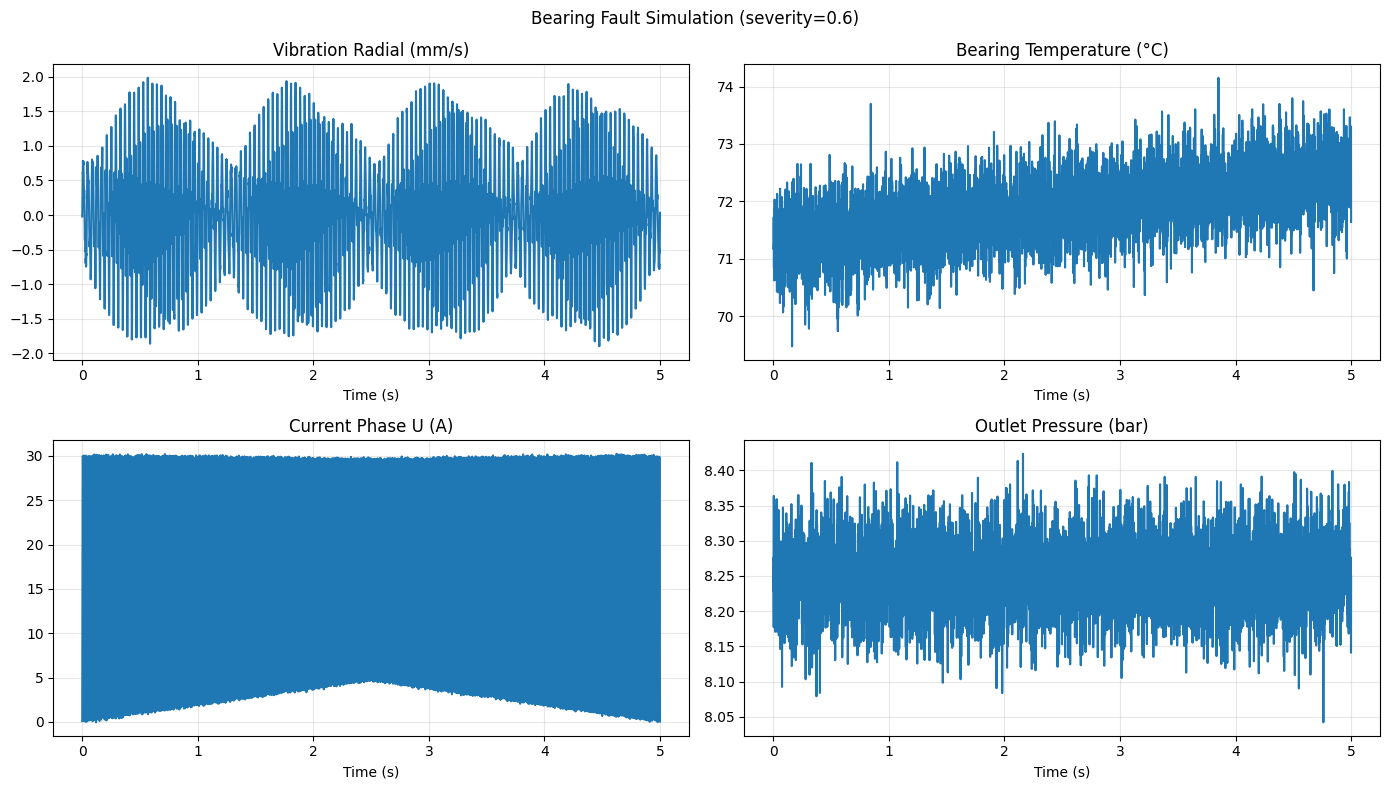

In [7]:
# Manual usage example
sim = MultiSensorSimulator({
    'rpm': 1500,
    'load': 0.75,
    'ambient_temp': 25,
    'sample_rate': 1000,
    'duration': 5
})

# Generate with specific parameters
data = sim.generate(
    noise_level=1.0,
    fault_type='bearing',
    fault_severity=0.6
)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0,0].plot(data['time'], data['vib_radial'])
axes[0,0].set_title('Vibration Radial (mm/s)')

axes[0,1].plot(data['time'], data['temp_bearing'])
axes[0,1].set_title('Bearing Temperature (°C)')

axes[1,0].plot(data['time'], data['current_u'])
axes[1,0].set_title('Current Phase U (A)')

axes[1,1].plot(data['time'], data['pressure_outlet'])
axes[1,1].set_title('Outlet Pressure (bar)')

for ax in axes.flat:
    ax.set_xlabel('Time (s)')
    ax.grid(True, alpha=0.3)

plt.suptitle('Bearing Fault Simulation (severity=0.6)')
plt.tight_layout()
plt.show()

## 5. JSON Export Formats

### Why JSON?

JSON is the universal data interchange format, making it ideal for:
- **Node-RED integration** - Direct use in flows via `msg.payload`
- **Web APIs** - REST endpoints for real-time dashboards
- **ML pipelines** - Many frameworks support JSON/JSONL
- **Logging** - Structured logs for analysis

### The 7 Export Formats

This notebook provides 7 different JSON formats, each optimized for a specific use case:

| # | Format | Use Case | When to Use |
|---|--------|----------|-------------|
| 1 | **Single Measurement** | Real-time sensor reading | Simulating individual sensor messages |
| 2 | **Multi-Sensor Snapshot** | Health Index calculation | All sensors at one timestamp |
| 3 | **Time Series Batch** | FFT / Signal analysis | Window of samples for frequency analysis |
| 4 | **Training JSONL** | ML model training | One sample per line, easy to stream |
| 5 | **Node-RED Messages** | Flow testing | Complete `msg` objects with config |
| 6 | **Labeled Dataset** | Complete ML dataset | Full dataset with metadata |
| 7 | **Streaming NDJSON** | Continuous data stream | Newline-delimited for streaming |

### Format Details - When to Use Which Format?

---

#### Format 1: Single Measurement

**What:** A single sensor reading at one point in time.

```json
{\"timestamp\": \"2026-01-18T17:30:00.000Z\", \"sensorId\": \"vib_axial\", \"value\": 2.34, \"unit\": \"mm/s\"}
```

**Why this format?**
- Simulates exactly how a real sensor sends data (MQTT, OPC-UA)
- Ideal for testing Node-RED flows with individual `msg.payload` values
- Minimal overhead, fast processing

**When to use:** Real-time anomaly detection where each measurement is processed individually.

---

#### Format 2: Multi-Sensor Snapshot

**What:** All 17 sensors at one point in time.

```json
{\"machineId\": \"pump_01\", \"sensors\": {\"vib_radial\": {\"value\": 2.34}, ...}, \"operatingConditions\": {...}}
```

**Why this format?**
- Health Index requires ALL sensors simultaneously for calculation
- Contains operating conditions (RPM, Load) for context-based evaluation
- Structured by machine for multi-asset monitoring

**When to use:** Health-Index Node, dashboard displays, condition reports.

---

#### Format 3: Time Series Batch

**What:** A window of samples for frequency analysis.

```json
{\"sensorId\": \"vib_radial\", \"sampleRate\": 1000, \"samples\": [0.12, 0.15, ...]}
```

**Why this format?**
- FFT requires contiguous samples with known sample rate
- Signal-Analyzer Node needs arrays, not single values
- Metadata (sampleRate) for correct frequency calculation

**When to use:** Signal-Analyzer Node (FFT, Peaks), vibration diagnostics.

---

#### Format 4: Training JSONL

**What:** One sample per line for ML training.

```
{\"features\": [2.3, 65.1, 12.4], \"label\": \"bearing\"}
{\"features\": [1.1, 45.2, 11.0], \"label\": \"normal\"}
```

**Why this format?**
- JSONL is streamable - no memory issues with millions of samples
- Simple parsing with `pandas.read_json(lines=True)`
- Each line is independent - parallel loading possible

**When to use:** Training scikit-learn, TensorFlow, PyTorch models with large datasets.

---

#### Format 5: Node-RED Messages

**What:** Complete `msg` objects for Node-RED.

```json
{\"payload\": 2.34, \"topic\": \"vibration/axial\", \"config\": {\"method\": \"zscore\", \"threshold\": 3.0}}
```

**Why this format?**
- Contains `msg.config` for dynamic node configuration (our feature!)
- Directly copyable into Node-RED Inject node
- Topic for routing in flows

**When to use:** Testing Node-RED flows, validating `msg.config` functionality.

---

#### Format 6: Labeled Dataset

**What:** Complete dataset with metadata.

```json
{\"datasetInfo\": {\"samples\": 1000, \"features\": [...], \"classes\": [...]}, \"data\": [...]}
```

**Why this format?**
- Self-describing - contains feature names, classes, creation date
- Reproducible - all info to trace training
- Standard for ML experiments (similar to sklearn.datasets)

**When to use:** Documented ML experiments, dataset versioning, team sharing.

---

#### Format 7: Streaming NDJSON

**What:** Continuous data stream (Newline-Delimited JSON).

```
{\"t\": 0.0, \"vib\": 1.2, \"temp\": 45.3}
{\"t\": 0.01, \"vib\": 1.3, \"temp\": 45.4}
```

**Why this format?**
- Minimal payload size (short keys)
- Streamable without full parsing
- Ideal for Kafka, MQTT, WebSocket streams

**When to use:** Real-time streaming tests, performance benchmarks, log files.

---

### Decision Guide: Which Format Do I Need?

| Use Case | Recommended Format | Reason |
|----------|-------------------|--------|
| Test Node-RED flow | **5 - Node-RED Messages** | Contains `msg.config` |
| Train ML model | **4 - JSONL** or **6 - Labeled Dataset** | Streamable / Self-describing |
| Calculate Health Index | **2 - Multi-Sensor Snapshot** | All sensors at once |
| FFT analysis | **3 - Time Series Batch** | Contiguous samples |
| Real-time simulation | **1 - Single** or **7 - NDJSON** | Minimal overhead |
| Document dataset | **6 - Labeled Dataset** | With metadata |

In [8]:
class JSONExporter:
    """
    Export sensor data in various JSON formats for different use cases.
    """
    
    def __init__(self, sensor_specs=None):
        self.sensor_specs = sensor_specs or MultiSensorSimulator.SENSOR_SPECS
    
    # =========================================================================
    # FORMAT 1: Single Sensor Measurement (Real-time)
    # =========================================================================
    def to_single_measurement(self, sensor_name, value, timestamp=None, quality='good'):
        """
        Single sensor reading - as it would come from a real sensor.
        Perfect for Node-RED msg.payload.
        
        Example output:
        {
            "timestamp": "2026-01-18T17:30:00.000Z",
            "sensorId": "pump_01_vib_axial",
            "value": 2.34,
            "unit": "mm/s",
            "quality": "good"
        }
        """
        spec = self.sensor_specs.get(sensor_name, {})
        return {
            'timestamp': timestamp or datetime.utcnow().isoformat() + 'Z',
            'sensorId': sensor_name,
            'value': float(value),
            'unit': spec.get('unit', ''),
            'quality': quality
        }
    
    # =========================================================================
    # FORMAT 2: Multi-Sensor Snapshot
    # =========================================================================
    def to_multi_sensor_snapshot(self, data, timestamp=None, machine_id='machine_01'):
        """
        All sensors at one point in time - for Health Index calculation.
        
        Example output:
        {
            "timestamp": "2026-01-18T17:30:00.000Z",
            "machineId": "pump_station_01",
            "sensors": {
                "vib_axial": {"value": 2.34, "unit": "mm/s"},
                ...
            },
            "operatingConditions": {...},
            "faultInfo": {...}
        }
        """
        # Get values at a specific index (middle by default)
        idx = len(data['time']) // 2
        
        sensors = {}
        for sensor_name in self.sensor_specs.keys():
            if sensor_name in data:
                spec = self.sensor_specs[sensor_name]
                sensors[sensor_name] = {
                    'value': round(float(data[sensor_name][idx]), 4),
                    'unit': spec['unit']
                }
        
        return {
            'timestamp': timestamp or datetime.utcnow().isoformat() + 'Z',
            'machineId': machine_id,
            'sensors': sensors,
            'operatingConditions': {
                'rpm': round(float(data['rpm'][idx]), 1) if 'rpm' in data else None,
                'load': round(float(data['load'][idx]), 1) if 'load' in data else None,
                'ambientTemp': round(float(data['temp_ambient'][idx]), 1) if 'temp_ambient' in data else None
            },
            'faultInfo': {
                'type': data.get('fault_type', 'unknown'),
                'severity': data.get('fault_severity', 0.0)
            }
        }
    
    # =========================================================================
    # FORMAT 3: Time Series Batch (for Signal Analysis)
    # =========================================================================
    def to_timeseries_batch(self, data, sensor_name, start_idx=0, window_size=1000):
        """
        Window of sensor values for FFT / signal analysis.
        
        Example output:
        {
            "sensorId": "motor_01_vib",
            "startTime": "2026-01-18T17:00:00Z",
            "sampleRate": 1000,
            "samples": [0.12, 0.15, 0.11, ...],
            "metadata": {...}
        }
        """
        if sensor_name not in data:
            raise ValueError(f"Sensor {sensor_name} not in data")
        
        spec = self.sensor_specs.get(sensor_name, {})
        samples = data[sensor_name][start_idx:start_idx + window_size]
        
        # Calculate sample rate from time array
        dt = data['time'][1] - data['time'][0] if len(data['time']) > 1 else 0.001
        sample_rate = int(1.0 / dt)
        
        return {
            'sensorId': sensor_name,
            'startTime': datetime.utcnow().isoformat() + 'Z',
            'sampleRate': sample_rate,
            'samples': [round(float(s), 6) for s in samples],
            'metadata': {
                'unit': spec.get('unit', ''),
                'faultType': data.get('fault_type', 'unknown'),
                'severity': data.get('fault_severity', 0.0),
                'windowSize': len(samples)
            }
        }
    
    # =========================================================================
    # FORMAT 4: Training Dataset (JSONL - one line per sample)
    # =========================================================================
    def to_training_jsonl(self, data, feature_sensors, label_key='fault_type', rul_key=None):
        """
        Generate training samples in JSONL format (one JSON per line).
        
        Example output (one line):
        {"features": [2.3, 1.8, 65, 12.4], "label": "bearing_fault", "rul": 120}
        """
        lines = []
        n_samples = len(data['time'])
        
        # Sample every N points to reduce size
        step = max(1, n_samples // 100)
        
        for i in range(0, n_samples, step):
            features = []
            for sensor in feature_sensors:
                if sensor in data:
                    features.append(round(float(data[sensor][i]), 4))
            
            sample = {
                'features': features,
                'label': data.get(label_key, 'unknown')
            }
            
            if rul_key and rul_key in data:
                sample['rul'] = int(data[rul_key][i]) if isinstance(data[rul_key], np.ndarray) else int(data[rul_key])
            
            lines.append(json.dumps(sample))
        
        return '\n'.join(lines)
    
    # =========================================================================
    # FORMAT 5: Node-RED Flow Compatible
    # =========================================================================
    def to_nodered_msg(self, value, topic='sensor/vibration', config=None):
        """
        Node-RED message format - directly usable in flows.
        
        Example output:
        {
            "payload": 2.34,
            "topic": "vibration/axial",
            "config": {
                "method": "zscore",
                "windowSize": 50,
                "threshold": 3.0
            }
        }
        """
        msg = {
            'payload': float(value) if isinstance(value, (int, float, np.floating)) else value,
            'topic': topic,
            '_msgid': f'sim_{datetime.utcnow().strftime("%Y%m%d%H%M%S%f")}'
        }
        
        if config:
            msg['config'] = config
        
        return msg
    
    def to_nodered_batch(self, data, sensor_name, node_type='anomaly-detector', sample_every=100):
        """
        Generate multiple Node-RED messages for testing flows.
        """
        messages = []
        spec = self.sensor_specs.get(sensor_name, {})
        
        # Default configs based on node type
        configs = {
            'anomaly-detector': {'method': 'zscore', 'windowSize': 50, 'zscoreThreshold': 3.0},
            'trend-predictor': {'mode': 'rate-of-change', 'windowSize': 20, 'rocThreshold': 0.1},
            'signal-analyzer': {'mode': 'fft', 'fftSize': 256, 'sampleRate': 1000},
            'health-index': {'healthyThreshold': 80, 'warningThreshold': 60}
        }
        
        config = configs.get(node_type, {})
        
        for i in range(0, len(data[sensor_name]), sample_every):
            msg = self.to_nodered_msg(
                value=data[sensor_name][i],
                topic=f'{sensor_name}/{spec.get("unit", "value")}',
                config=config
            )
            msg['timestamp'] = float(data['time'][i])
            messages.append(msg)
        
        return messages
    
    # =========================================================================
    # FORMAT 6: Labeled Dataset with Metadata
    # =========================================================================
    def to_labeled_dataset(self, data_list, feature_sensors, dataset_name='sensor_dataset'):
        """
        Complete labeled dataset for ML training.
        
        Args:
            data_list: List of data dicts from multiple generate() calls
            feature_sensors: List of sensor names to use as features
        
        Example output:
        {
            "datasetInfo": {
                "name": "pump_fault_dataset",
                "created": "2026-01-18",
                "samples": 1000,
                "features": ["vib_rms", "temp_diff", ...],
                "classes": ["normal", "bearing", ...]
            },
            "data": [
                {"x": [2.3, 5.1, 0.02], "y": "normal", "severity": 0.0},
                ...
            ]
        }
        """
        samples = []
        classes = set()
        
        for data in data_list:
            n_points = len(data['time'])
            fault_type = data.get('fault_type', 'unknown')
            severity = data.get('fault_severity', 0.0)
            classes.add(fault_type)
            
            # Extract statistical features per sensor
            features = []
            feature_names = []
            
            for sensor in feature_sensors:
                if sensor in data:
                    vals = data[sensor]
                    features.extend([
                        round(float(np.mean(vals)), 4),
                        round(float(np.std(vals)), 4),
                        round(float(np.max(vals)), 4),
                        round(float(np.sqrt(np.mean(vals**2))), 4)  # RMS
                    ])
                    if not feature_names:
                        feature_names.extend([f'{sensor}_mean', f'{sensor}_std', f'{sensor}_max', f'{sensor}_rms'])
            
            samples.append({
                'x': features,
                'y': fault_type,
                'severity': severity
            })
        
        # Build feature names for all sensors
        all_feature_names = []
        for sensor in feature_sensors:
            all_feature_names.extend([f'{sensor}_mean', f'{sensor}_std', f'{sensor}_max', f'{sensor}_rms'])
        
        return {
            'datasetInfo': {
                'name': dataset_name,
                'created': datetime.utcnow().strftime('%Y-%m-%d'),
                'samples': len(samples),
                'features': all_feature_names,
                'classes': sorted(list(classes)),
                'featureDimension': len(features) if samples else 0
            },
            'data': samples
        }
    
    # =========================================================================
    # FORMAT 7: Streaming NDJSON (Newline Delimited JSON)
    # =========================================================================
    def to_streaming_ndjson(self, data, sensors=None, sample_every=10):
        """
        Continuous data stream format - one JSON object per line.
        
        Example output:
        {"t": 0.0, "vib": 1.2, "temp": 45.3}
        {"t": 0.01, "vib": 1.3, "temp": 45.4}
        ...
        """
        sensors = sensors or ['vib_radial', 'temp_bearing', 'current_u']
        lines = []
        
        for i in range(0, len(data['time']), sample_every):
            record = {'t': round(float(data['time'][i]), 4)}
            for sensor in sensors:
                if sensor in data:
                    # Use short key names for streaming
                    short_name = sensor.replace('_', '').replace('vib', 'v').replace('temp', 't').replace('current', 'i').replace('pressure', 'p')
                    record[short_name[:6]] = round(float(data[sensor][i]), 4)
            lines.append(json.dumps(record))
        
        return '\n'.join(lines)
    
    # =========================================================================
    # HELPER: Save to file
    # =========================================================================
    def save_json(self, data, filename, pretty=True):
        """Save JSON data to file."""
        with open(filename, 'w') as f:
            if pretty:
                json.dump(data, f, indent=2)
            else:
                json.dump(data, f)
        return filename
    
    def save_jsonl(self, content, filename):
        """Save JSONL/NDJSON content to file."""
        with open(filename, 'w') as f:
            f.write(content)
        return filename


print("JSONExporter defined with 7 export formats")

JSONExporter defined with 7 export formats


### 5.1 Interactive JSON Export UI

The `JSONExportUI` provides a graphical interface for generating JSON in any of the 7 formats.

**How to use:**
1. Select the desired **Format** from the dropdown
2. Choose which **Sensors** to include
3. For Node-RED format, select the target **Node Type**
4. Click **"Generate & Export"** to see the JSON preview
5. Click **"Save to File"** to save to disk

The generated JSON appears in the text area below and can be copied directly into Node-RED or other tools.

In [9]:
if HAS_WIDGETS:
    
    class JSONExportUI:
        def __init__(self):
            self.simulator = MultiSensorSimulator()
            self.exporter = JSONExporter()
            self.current_data = None
            self._create_widgets()
            self._setup_layout()
        
        def _create_widgets(self):
            # Quick generate settings
            self.fault_type = widgets.Dropdown(
                options=['normal', 'unbalance', 'misalignment', 'bearing', 'overload', 'cavitation'],
                value='bearing',
                description='Fault:',
                style={'description_width': '80px'}
            )
            
            self.severity = widgets.FloatSlider(
                value=0.5, min=0.0, max=1.0, step=0.1,
                description='Severity:',
                style={'description_width': '80px'}
            )
            
            # Export format selection
            self.format_select = widgets.Dropdown(
                options=[
                    ('1. Single Measurement (Real-time)', 'single'),
                    ('2. Multi-Sensor Snapshot', 'snapshot'),
                    ('3. Time Series Batch', 'timeseries'),
                    ('4. Training JSONL', 'jsonl'),
                    ('5. Node-RED Messages', 'nodered'),
                    ('6. Labeled Dataset', 'labeled'),
                    ('7. Streaming NDJSON', 'streaming')
                ],
                value='snapshot',
                description='Format:',
                style={'description_width': '80px'}
            )
            
            # Sensor selection for formats that need it
            self.sensor_select = widgets.SelectMultiple(
                options=list(MultiSensorSimulator.SENSOR_SPECS.keys()),
                value=['vib_radial', 'temp_bearing', 'current_u'],
                description='Sensors:',
                rows=5,
                style={'description_width': '80px'}
            )
            
            # Node-RED specific options
            self.node_type = widgets.Dropdown(
                options=['anomaly-detector', 'trend-predictor', 'signal-analyzer', 'health-index'],
                value='anomaly-detector',
                description='Node:',
                style={'description_width': '80px'}
            )
            
            # Buttons
            self.generate_btn = widgets.Button(
                description='Generate & Export',
                button_style='primary',
                icon='play'
            )
            self.generate_btn.on_click(self._on_generate)
            
            self.save_btn = widgets.Button(
                description='Save to File',
                button_style='success',
                icon='download'
            )
            self.save_btn.on_click(self._on_save)
            
            self.copy_btn = widgets.Button(
                description='Copy to Clipboard',
                button_style='info',
                icon='copy'
            )
            
            # Output areas
            self.json_output = widgets.Textarea(
                placeholder='Generated JSON will appear here...',
                layout=widgets.Layout(width='100%', height='400px')
            )
            self.status = widgets.HTML(value='<i>Select format and click Generate</i>')
            
            self.current_json = None
            self.current_format = None
        
        def _setup_layout(self):
            settings_box = widgets.VBox([
                widgets.HTML('<b>Data Generation</b>'),
                self.fault_type,
                self.severity,
            ])
            
            format_box = widgets.VBox([
                widgets.HTML('<b>Export Format</b>'),
                self.format_select,
                self.node_type,
            ])
            
            sensor_box = widgets.VBox([
                widgets.HTML('<b>Sensors</b>'),
                self.sensor_select,
            ])
            
            controls = widgets.HBox([settings_box, format_box, sensor_box])
            buttons = widgets.HBox([self.generate_btn, self.save_btn])
            
            self.layout = widgets.VBox([
                widgets.HTML('<h2>JSON Export Generator</h2>'),
                controls,
                buttons,
                self.status,
                widgets.HTML('<b>Generated JSON:</b>'),
                self.json_output
            ])
        
        def _on_generate(self, btn):
            # Generate data
            self.current_data = self.simulator.generate(
                noise_level=1.0,
                fault_type=self.fault_type.value,
                fault_severity=self.severity.value
            )
            
            fmt = self.format_select.value
            self.current_format = fmt
            sensors = list(self.sensor_select.value)
            
            try:
                if fmt == 'single':
                    # Single measurement for first selected sensor
                    sensor = sensors[0] if sensors else 'vib_radial'
                    idx = len(self.current_data['time']) // 2
                    result = self.exporter.to_single_measurement(
                        sensor, self.current_data[sensor][idx]
                    )
                    self.current_json = json.dumps(result, indent=2)
                
                elif fmt == 'snapshot':
                    result = self.exporter.to_multi_sensor_snapshot(
                        self.current_data, machine_id='pump_station_01'
                    )
                    self.current_json = json.dumps(result, indent=2)
                
                elif fmt == 'timeseries':
                    sensor = sensors[0] if sensors else 'vib_radial'
                    result = self.exporter.to_timeseries_batch(
                        self.current_data, sensor, window_size=500
                    )
                    self.current_json = json.dumps(result, indent=2)
                
                elif fmt == 'jsonl':
                    self.current_json = self.exporter.to_training_jsonl(
                        self.current_data, sensors
                    )
                
                elif fmt == 'nodered':
                    sensor = sensors[0] if sensors else 'vib_radial'
                    messages = self.exporter.to_nodered_batch(
                        self.current_data, sensor, 
                        node_type=self.node_type.value,
                        sample_every=500
                    )
                    self.current_json = json.dumps(messages, indent=2)
                
                elif fmt == 'labeled':
                    # Generate multiple fault types for a complete dataset
                    data_list = []
                    for fault in ['normal', 'unbalance', 'bearing', 'misalignment']:
                        for sev in [0.0, 0.3, 0.6, 0.9]:
                            if fault == 'normal':
                                sev = 0.0
                            d = self.simulator.generate(
                                noise_level=1.0, fault_type=fault, fault_severity=sev
                            )
                            data_list.append(d)
                        if fault == 'normal':
                            break  # Only one normal sample
                    
                    result = self.exporter.to_labeled_dataset(
                        data_list, sensors, dataset_name='fault_classification_dataset'
                    )
                    self.current_json = json.dumps(result, indent=2)
                
                elif fmt == 'streaming':
                    self.current_json = self.exporter.to_streaming_ndjson(
                        self.current_data, sensors, sample_every=50
                    )
                
                self.json_output.value = self.current_json
                lines = len(self.current_json.split('\n'))
                self.status.value = f'<span style="color:green">✓ Generated {fmt} format ({lines} lines)</span>'
                
            except Exception as e:
                self.status.value = f'<span style="color:red">Error: {str(e)}</span>'
        
        def _on_save(self, btn):
            if not self.current_json:
                self.status.value = '<span style="color:red">Generate data first!</span>'
                return
            
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            fmt = self.current_format
            
            if fmt in ['jsonl', 'streaming']:
                ext = 'jsonl' if fmt == 'jsonl' else 'ndjson'
                filename = f'{DATA_DIR}/export_{fmt}_{timestamp}.{ext}'
                self.exporter.save_jsonl(self.current_json, filename)
            else:
                filename = f'{DATA_DIR}/export_{fmt}_{timestamp}.json'
                with open(filename, 'w') as f:
                    f.write(self.current_json)
            
            self.status.value = f'<span style="color:green">✓ Saved to {filename}</span>'
        
        def display(self):
            display(self.layout)
    
    print("JSONExportUI defined")

JSONExportUI defined


In [10]:
# Display the JSON Export UI
if HAS_WIDGETS:
    json_ui = JSONExportUI()
    json_ui.display()

### 5.2 Manual JSON Export Examples

The following cells demonstrate each JSON format programmatically. This is useful when:
- Integrating into automated pipelines
- Understanding the exact structure of each format
- Customizing the export parameters

Each format is shown with sample output so you can see exactly what data structure to expect.

In [11]:
# Manual usage examples
print("=" * 60)
print("JSON EXPORT EXAMPLES")
print("=" * 60)

# Generate sample data
sim = MultiSensorSimulator({
    'rpm': 1500, 'load': 0.7, 'ambient_temp': 25,
    'sample_rate': 1000, 'duration': 5
})
data = sim.generate(noise_level=1.0, fault_type='bearing', fault_severity=0.6)

exporter = JSONExporter()

# FORMAT 1: Single Measurement
print("\n--- FORMAT 1: Single Measurement ---")
single = exporter.to_single_measurement('vib_radial', data['vib_radial'][500])
print(json.dumps(single, indent=2))

# FORMAT 2: Multi-Sensor Snapshot
print("\n--- FORMAT 2: Multi-Sensor Snapshot ---")
snapshot = exporter.to_multi_sensor_snapshot(data, machine_id='pump_01')
print(json.dumps(snapshot, indent=2))

JSON EXPORT EXAMPLES



--- FORMAT 1: Single Measurement ---
{
  "timestamp": "2026-01-18T18:09:57.966571Z",
  "sensorId": "vib_radial",
  "value": 0.8857913991449171,
  "unit": "mm/s",
  "quality": "good"
}

--- FORMAT 2: Multi-Sensor Snapshot ---
{
  "timestamp": "2026-01-18T18:09:57.966787Z",
  "machineId": "pump_01",
  "sensors": {
    "vib_axial": {
      "value": 0.0086,
      "unit": "mm/s"
    },
    "vib_radial": {
      "value": -0.0514,
      "unit": "mm/s"
    },
    "vib_tangential": {
      "value": -0.0158,
      "unit": "mm/s"
    },
    "temp_bearing": {
      "value": 71.6291,
      "unit": "\u00b0C"
    },
    "temp_motor": {
      "value": 84.0729,
      "unit": "\u00b0C"
    },
    "temp_oil": {
      "value": 57.645,
      "unit": "\u00b0C"
    },
    "temp_ambient": {
      "value": 24.9795,
      "unit": "\u00b0C"
    },
    "current_u": {
      "value": 4.6079,
      "unit": "A"
    },
    "current_v": {
      "value": 22.6981,
      "unit": "A"
    },
    "current_w": {
      "value

/tmp/ipykernel_97460/2787999923.py:28: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': timestamp or datetime.utcnow().isoformat() + 'Z',
/tmp/ipykernel_97460/2787999923.py:67: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': timestamp or datetime.utcnow().isoformat() + 'Z',


In [12]:
# FORMAT 3: Time Series Batch
print("--- FORMAT 3: Time Series Batch ---")
ts_batch = exporter.to_timeseries_batch(data, 'vib_radial', window_size=100)
# Print truncated for display
ts_display = ts_batch.copy()
ts_display['samples'] = ts_display['samples'][:10] + ['...'] + ts_display['samples'][-3:]
print(json.dumps(ts_display, indent=2))

# FORMAT 4: Training JSONL
print("\n--- FORMAT 4: Training JSONL (first 5 lines) ---")
jsonl = exporter.to_training_jsonl(data, ['vib_radial', 'temp_bearing', 'current_u'])
for line in jsonl.split('\n')[:5]:
    print(line)

--- FORMAT 3: Time Series Batch ---
{
  "sensorId": "vib_radial",
  "startTime": "2026-01-18T18:09:57.974321Z",
  "sampleRate": 999,
  "samples": [
    0.078846,
    0.17328,
    0.237616,
    0.481903,
    0.56428,
    0.640233,
    0.740261,
    0.704171,
    0.733805,
    0.694123,
    "...",
    0.292676,
    0.153334,
    0.02945
  ],
  "metadata": {
    "unit": "mm/s",
    "faultType": "bearing",
    "severity": 0.6,
    "windowSize": 100
  }
}

--- FORMAT 4: Training JSONL (first 5 lines) ---
{"features": [0.0788, 70.2456, -0.071], "label": "bearing"}
{"features": [0.5226, 71.0674, 0.1336], "label": "bearing"}
{"features": [-0.2789, 70.6925, 0.4604], "label": "bearing"}
{"features": [-0.5064, 69.9957, 0.4134], "label": "bearing"}
{"features": [0.6244, 69.8668, 0.4344], "label": "bearing"}


/tmp/ipykernel_97460/2787999923.py:109: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'startTime': datetime.utcnow().isoformat() + 'Z',


In [13]:
# FORMAT 5: Node-RED Messages
print("--- FORMAT 5: Node-RED Messages ---")
nodered_msgs = exporter.to_nodered_batch(data, 'vib_radial', node_type='anomaly-detector', sample_every=1000)
print(f"Generated {len(nodered_msgs)} messages")
print("First message:")
print(json.dumps(nodered_msgs[0], indent=2))

# FORMAT 7: Streaming NDJSON
print("\n--- FORMAT 7: Streaming NDJSON (first 10 lines) ---")
ndjson = exporter.to_streaming_ndjson(data, ['vib_radial', 'temp_bearing'], sample_every=100)
for line in ndjson.split('\n')[:10]:
    print(line)

--- FORMAT 5: Node-RED Messages ---
Generated 5 messages
First message:
{
  "payload": 0.07884615600917738,
  "topic": "vib_radial/mm/s",
  "_msgid": "sim_20260118180957983871",
  "config": {
    "method": "zscore",
    "windowSize": 50,
    "zscoreThreshold": 3.0
  },
  "timestamp": 0.0
}

--- FORMAT 7: Streaming NDJSON (first 10 lines) ---
{"t": 0.0, "vradia": 0.0788, "tbeari": 70.2456}
{"t": 0.1, "vradia": -0.2789, "tbeari": 70.6925}
{"t": 0.2, "vradia": 0.6244, "tbeari": 69.8668}
{"t": 0.3001, "vradia": -0.5789, "tbeari": 70.3441}
{"t": 0.4001, "vradia": -0.0854, "tbeari": 70.0801}
{"t": 0.5001, "vradia": 0.8858, "tbeari": 70.3967}
{"t": 0.6001, "vradia": -1.2193, "tbeari": 71.158}
{"t": 0.7001, "vradia": 0.8294, "tbeari": 70.5226}
{"t": 0.8002, "vradia": 0.1314, "tbeari": 70.9823}
{"t": 0.9002, "vradia": -0.7645, "tbeari": 70.4125}


/tmp/ipykernel_97460/2787999923.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  '_msgid': f'sim_{datetime.utcnow().strftime("%Y%m%d%H%M%S%f")}'


In [14]:
# FORMAT 6: Labeled Dataset
print("--- FORMAT 6: Labeled Dataset ---")

# Generate data for multiple conditions
data_list = []
for fault in ['normal', 'bearing', 'unbalance']:
    for severity in [0.0, 0.5, 1.0]:
        if fault == 'normal' and severity > 0:
            continue
        d = sim.generate(noise_level=1.0, fault_type=fault, fault_severity=severity)
        data_list.append(d)

labeled_dataset = exporter.to_labeled_dataset(
    data_list, 
    ['vib_radial', 'temp_bearing'], 
    dataset_name='pump_fault_dataset'
)

print(f"Dataset Info:")
print(json.dumps(labeled_dataset['datasetInfo'], indent=2))
print(f"\nFirst 3 samples:")
for sample in labeled_dataset['data'][:3]:
    print(json.dumps(sample))

--- FORMAT 6: Labeled Dataset ---
Dataset Info:
{
  "name": "pump_fault_dataset",
  "created": "2026-01-18",
  "samples": 7,
  "features": [
    "vib_radial_mean",
    "vib_radial_std",
    "vib_radial_max",
    "vib_radial_rms",
    "temp_bearing_mean",
    "temp_bearing_std",
    "temp_bearing_max",
    "temp_bearing_rms"
  ],
  "classes": [
    "bearing",
    "normal",
    "unbalance"
  ],
  "featureDimension": 8
}

First 3 samples:
{"x": [0.0004, 0.5133, 0.8841, 0.5133, 70.5089, 0.4999, 72.1298, 70.5106], "y": "normal", "severity": 0.0}
{"x": [-0.0007, 0.5143, 0.9085, 0.5143, 70.4986, 0.4893, 72.4125, 70.5003], "y": "bearing", "severity": 0.0}
{"x": [0.0002, 0.7171, 1.797, 0.7171, 70.9929, 0.5802, 73.1451, 70.9953], "y": "bearing", "severity": 0.5}


/tmp/ipykernel_97460/2787999923.py:276: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'created': datetime.utcnow().strftime('%Y-%m-%d'),


In [15]:
# Save all formats to files
print("\n" + "=" * 60)
print("SAVING EXAMPLES TO FILES")
print("=" * 60)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save each format
files_saved = []

# 1. Single measurement
f1 = f'{DATA_DIR}/example_single_measurement.json'
exporter.save_json(single, f1)
files_saved.append(f1)

# 2. Multi-sensor snapshot
f2 = f'{DATA_DIR}/example_multi_sensor_snapshot.json'
exporter.save_json(snapshot, f2)
files_saved.append(f2)

# 3. Time series batch
f3 = f'{DATA_DIR}/example_timeseries_batch.json'
exporter.save_json(ts_batch, f3)
files_saved.append(f3)

# 4. Training JSONL
f4 = f'{DATA_DIR}/example_training.jsonl'
exporter.save_jsonl(jsonl, f4)
files_saved.append(f4)

# 5. Node-RED batch
f5 = f'{DATA_DIR}/example_nodered_messages.json'
exporter.save_json(nodered_msgs, f5)
files_saved.append(f5)

# 6. Labeled dataset
f6 = f'{DATA_DIR}/example_labeled_dataset.json'
exporter.save_json(labeled_dataset, f6)
files_saved.append(f6)

# 7. Streaming NDJSON
f7 = f'{DATA_DIR}/example_streaming.ndjson'
exporter.save_jsonl(ndjson, f7)
files_saved.append(f7)

print("\nFiles saved:")
for f in files_saved:
    size = os.path.getsize(f)
    print(f"  {f} ({size:,} bytes)")


SAVING EXAMPLES TO FILES

Files saved:
  ../data/simulated/example_single_measurement.json (146 bytes)
  ../data/simulated/example_multi_sensor_snapshot.json (1,457 bytes)
  ../data/simulated/example_timeseries_batch.json (1,657 bytes)
  ../data/simulated/example_training.jsonl (6,022 bytes)
  ../data/simulated/example_nodered_messages.json (1,269 bytes)
  ../data/simulated/example_labeled_dataset.json (1,917 bytes)
  ../data/simulated/example_streaming.ndjson (2,553 bytes)


## Summary

### JSON Export Formats

| # | Format | Use Case | File Type |
|---|--------|----------|----------|
| 1 | Single Measurement | Real-time sensor reading | `.json` |
| 2 | Multi-Sensor Snapshot | Health Index calculation | `.json` |
| 3 | Time Series Batch | FFT / Signal analysis | `.json` |
| 4 | Training JSONL | ML model training | `.jsonl` |
| 5 | Node-RED Messages | Flow testing | `.json` |
| 6 | Labeled Dataset | Complete ML dataset | `.json` |
| 7 | Streaming NDJSON | Continuous data stream | `.ndjson` |

### Available Sensors (17 total)

| Category | Sensors | Units |
|----------|---------|-------|
| **Vibration** | axial, radial, tangential | mm/s |
| **Temperature** | bearing, motor, oil, ambient | °C |
| **Electrical** | current_u/v/w, voltage | A, V |
| **Process** | pressure_in/out, flow, rpm, load, power | bar, m³/h, rpm, %, kW |

### Fault Types

| Fault | Effect |
|-------|--------|
| normal | Baseline operation |
| unbalance | Elevated 1x vibration |
| misalignment | Elevated 2x, 3x vibration |
| bearing | High-frequency impulses |
| overload | Increased current, temperature |
| cavitation | Broadband noise, pressure drop |